<a href="https://colab.research.google.com/github/rdr453/ChainLink/blob/main/Practicals/Practical4/Practical_4_American_Sign_Language_ResNet_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSE 40868: Neural Networks - Spring 2025

## Practical 4: American Sign Language ResNet Model

![HearView Diagram](https://www.hearview.ai/cdn/shop/articles/1_M2-KzpsiRFfMdNxpRgTf6A_34b99d0c-58a5-42f1-8ded-e45eabfbc4f4_750x.png?v=1738821201)

Author: Benjamin Sporrer, Bobby Rizzo


_New: March 25, 2025_

Logistics:
 * Using the "File > Save to Github" menu above, save a copy of this notebook to your class Github repo. Maks sure you save it in the `Practicals/Practical4` folder by prepending `Practicals/Practical4/` to the notebook file name.
 * Study and run the notebook *before class on March 26*.
 * Arrive in class ready to do some of the work required.
 * Finish up your work and commit the changes to your repo, and finish the work by 11:59pm on Wednesday, March 26th.

## 1. Install

In [5]:
# Install required Python packages:
# - grad-cam: for visualizing model attention using Grad-CAM
# - scikit-learn: for evaluation tools like classification report and confusion matrix
!pip install grad-cam scikit-learn torchinfo

## 2. Import

If you add additional imports put them here.

In [6]:
# Import libraries
import os
import zipfile
import gdown
import torch
import random
import string
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
from PIL import Image
from collections import Counter, defaultdict
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedShuffleSplit
from torchinfo import summary

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F_nn  # Student Added

import torchvision.transforms.functional as F
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision import transforms
from torchvision.utils import make_grid, save_image
from torchvision.datasets import ImageFolder
from torchvision.datasets.folder import default_loader
from torchvision.transforms.functional import resize

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

## 3. Residual Networks (Student Work Required)
Residual Networks (ResNets) are a class of deep learning architectures that introduced the concept of *skip connections* to address the vanishing gradient problem in deep networks. Traditional deep neural networks suffer from performance degradation as depth increases due to gradient vanishing or exploding issues. ResNets allow for deeper networks by incorporating identity mappings that bypass certain layers, making training more efficient and enabling better gradient flow.

### Understanding Residual Blocks
A Basic Residual Block consists of:
1. **Two Convolutional Layers** (3x3 kernels)
2. **Batch Normalization** after each convolution
3. **ReLU Activation** applied after batch normalization
4. **Skip Connection (Identity Mapping):** The input is directly added to the output of the convolutions, helping gradients flow efficiently.
5. **Downsampling (if needed):** When feature map sizes change due to striding, a 1x1 convolution is used to match dimensions.

**Note:** There are other types of residual blocks used in deeper ResNet models. They are referred to as Bottleneck Residual Blocks.

The key innovation is the skip connection (+ Input) that adds the original input to the transformed features. If the input and output dimensions don’t match, a downsample shortcut (typically a 1x1 convolution) is used to reshape the input before addition.

This structure enables the network to learn residual functions (i.e., what has changed) rather than the full mapping, making it easier to optimize deeper architectures.



In [4]:
class ResidualBlock(nn.Module):
    """
    A basic residual block used in ResNet. It applies two convolutional layers with
    batch normalization and ReLU activation, plus a skip connection to preserve gradient flow.
    """
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()

        # -----------------------
        # Convolutional Layer
        # -----------------------
        # 1st Convolutional Layer:
        # - Input Channels variable
        # - Output Channels variable
        # - Kernel Size: 3x3 (each filter is 3x3 in size)
        # - Stride: variable (default is 1, but can be set for spatial downsampling)
        # - Padding: 1 (ensures that spatial dimensions are preserved when stride=1)
        # - bias=False: disables the learnable bias term in the convolution.
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)

        # -----------------------
        # Batch Normalization Layer
        # -----------------------
        # 1st BatchNorm Layer:
        # - Normalizes the output of the previous convolutional layer (per channel)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # -----------------------
        # Activation Function
        # -----------------------
        # ReLU Activation
        # - Use 'nn.ReLU'
        # - inplace=True: saves memory by modifying input directly
        self.relu = nn.ReLU(inplace=True)

        # -----------------------
        # Convolutional Layer
        # -----------------------
        # 2nd Convolutional Layer:
        # - Input Channels: same as output of the previous layer (out_channels)
        # - Output Channels: same (no change in feature map depth)
        # - Kernel Size: 3x3
        # - Stride: 1 (preserves spatial dimensions)
        # - Padding: 1 (ensures output size matches input size when stride=1)
        # - bias=False: bias is omitted because BatchNorm follows this layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)

        # -----------------------
        # Batch Normalization Layer
        # -----------------------
        # 2nd BatchNorm Layer:
        self.bn2 = nn.BatchNorm2d(out_channels)

        # -----------------------
        # Downsampling Layer (Optional)
        # -----------------------
        # - Used to match dimensions between the input (identity) and the output of the block
        self.downsample = downsample

    def forward(self, x):
        identity = x  # Save original input to add later

        # Apply downsampling to the identity if required (for dimension matching)
        if self.downsample is not None:
            identity = self.downsample(x)

        # Pass input through the residual block
        out = self.conv1(x)    # 1st Conv layer
        out = self.bn1(out)    # 1st BatchNorm layer
        out = self.relu(out)   # Activation Function

        out = self.conv2(out)  # 2nd Conv layer
        out = self.bn2(out)    # 2nd BatchNorm layer

        # Add skip connection (original input) to the output
        out += identity
        out = self.relu(out)   # Activation Function

        return out


### CustomResNet architecture:

- Initial convolution layer

  - Maps 3 input channels (RGB) to 64 output channels
  - Uses a 3×3 kernel, stride 1, and padding 1

- Four residual layers, each containing two `ResidualBlock` modules:

  - `layer1`: 64 output channels, no downsampling (stride = 1)

  - `layer2`: 128 output channels, with downsampling (stride = 2)

  - `layer3`: 256 output channels, with downsampling (stride = 2)

  - `layer4`: 512 output channels, with downsampling (stride = 2)

- Adaptive Average Pooling Layer

  -  Reduces Feature Maps to Fixed Size (1×1 per channel)
    
    - After the final residual layer, feature maps might be of size 4×4, 7×7, or even larger depending on the input resolution.

    - Adaptive average pooling reduces them to 1×1 per channel, no matter the input size.

    - This outputs a fixed-length vector ([batch_size, channels, 1, 1]), which can be easily flattened and passed to a fully connected layer.

  - Enables Variable Input Sizes

    - Because it's adaptive, it doesn't depend on a hardcoded kernel size.

    - You can input images of different resolutions, and the network will still produce the correct shape for the classifier.

  - Global Spatial Information Compression
    
    - Averaging over the entire spatial dimension (e.g., 4×4 → 1×1) effectively captures global context per feature map.

    - It helps the model focus on “what” is present rather than “where” it is — which is desirable for classification.

  - Reduces Parameters Compared to Flattening Large Feature Maps

    - Without pooling, flattening a large feature map (e.g., 512×4×4 = 8192) would result in a massive fully connected layer.

    - Pooling down to 512×1×1 means far fewer parameters, which improves efficiency and reduces overfitting risk.

- Fully Connected (FC) Layer

  - Maps the pooled 512-dimensional vector to `num_classes` output logits

- Each layer is created with `_make_layer(...)`, which:

  -  Applies downsampling via a 1×1 convolution when needed (e.g., due to stride > 1 or channel mismatch)

  - Stacks the specified number of ResidualBlock modules (two per layer)

In [8]:
# Custom simplified ResNet architecture using the custom ResidualBlock
class CustomResNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet, self).__init__()

        # -----------------------
        # Channel Tracking Variable
        # -----------------------
        # Initially set to 64
        self.in_channels = 64

        # -----------------------
        # Initial Convolutional Layer
        # -----------------------
        # Maps 3 input channels (RGB) to 64 output channels with a 3x3 kernel,
        # stride 1, padding 1, and no bias (since BatchNorm follows).
        self.conv = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

        # -----------------------
        # Batch Normalization Layer
        # -----------------------
        self.bn = nn.BatchNorm2d(64)

        # -----------------------
        # Activation Function
        # -----------------------
        self.relu = nn.ReLU(inplace=True)

        # -----------------------
        # Residual Layers
        # -----------------------
        # Each layer is built using _make_layer(...) to stack ResidualBlock modules.
        self.layer1 = self._make_layer(64, blocks=2, stride=1)   # No downsampling
        self.layer2 = self._make_layer(128, blocks=2, stride=2)  # Downsampling with stride=2
        self.layer3 = self._make_layer(256, blocks=2, stride=2)  # Downsampling with stride=2
        self.layer4 = self._make_layer(512, blocks=2, stride=2)  # Downsampling with stride=2

        # -----------------------
        # Adaptive Average Pooling Layer
        # -----------------------
        # Reduces spatial dimensions to 1×1 per channel regardless of input size.
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # -----------------------
        # Fully Connected Layer (Classification Head)
        # -----------------------
        # Maps the pooled 512-channel feature vector to num_classes logits.
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, stride):
        """
        Creates a sequence of residual blocks.

        Parameters:
            out_channels (int): Number of output channels for the blocks.
            blocks (int): Total number of ResidualBlock modules in the layer.
            stride (int): Stride for the first block (used for downsampling).

        Returns:
            nn.Sequential: A sequential container of residual blocks.
        """
        downsample = None

        # Downsampling is applied when stride is not 1 or if channel dimensions differ.
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = [ResidualBlock(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels  # Update input channels for subsequent blocks

        # Append additional residual blocks without further downsampling.
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        # Resize input to 32x32 to ensure consistent processing.
        # Using torch.nn.functional.interpolate to avoid conflict with torchvision.transforms.functional
        x = torch.nn.functional.interpolate(x, size=(32, 32), mode='bilinear', align_corners=False)

        # Initial Convolution + BatchNorm + ReLU Activation
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)

        # Pass through the four residual layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Adaptive average pooling reduces spatial dimensions to 1x1
        x = self.avgpool(x)
        # Flatten the feature map to create a feature vector
        x = torch.flatten(x, 1)

        enc = x  # Encoded feature vector (useful for visualization techniques like Grad-CAM)

        # Fully connected layer for classification
        x = self.fc(x)

        return x, enc

## 4. Download and Unzip Datasets

These functions will download and unzip the multiple ASL datasets used in this practical. The original datasets are structured such that each image is a member of a subdirectories that represents its class label. The format is one of the standard ones used in computer vision.

We are brining in multiple datasets so that we can later combine them. By combining same-domain datasets we give our model multiple varying "views" of the same concept, which hopefully results in a model that is smarter, more flexible, and more reliable in the real world.

Reasons why this is beneficial:

1. Improved Generalization

    - Datasets collected under different lighting, backgrounds, hand sizes, or camera angles help the model become more robust.

    - The model learns to focus on semantic features (the actual sign) instead of overfitting to the style or environment of just one dataset.

2. Greater Data Diversity

  - Different datasets may contain:

    - Varying hand shapes or skin tones

    - Different users

    - More variation in gesture representation

    - This increases intra-class variance, which helps prevent the model from being overly sensitive to specific representations.

3. Reduced Overfitting
  
  - Relying solely on a single dataset may cause the model to memorize dataset-specific patterns.

  - Adding more data from similar domains helps the model generalize better to new, unseen data (like webcam input).

4. Enhanced Performance on Real-World Data
  - Real-world scenarios are noisy and unpredictable.

  - By exposing your model to multiple styles and collection conditions, you prepare it for deployment in practical settings.

5. Compensate for Weaknesses in Individual Datasets
  
  - Some datasets might have class imbalance, low resolution, or mislabeled examples.

  - Combining with a second or third (or more) dataset can balance and complement these shortcomings.

In [9]:
def download_file_from_gdrive(file_id, output_path):
    if os.path.exists(output_path):
        print(f"{output_path} already exists. Skipping download.")
    else:
        url = f"https://drive.google.com/uc?id={file_id}"
        print(f"Downloading {output_path} from Google Drive...")
        gdown.download(url, output_path, quiet=False)

def unzip_dataset(zip_path, extract_dir, label="Dataset"):
    os.makedirs(extract_dir, exist_ok=True)

    if os.listdir(extract_dir):
        print(f"{label} already unzipped.")
        return

    print(f"Unzipping {label}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        members = [m for m in zip_ref.namelist() if not m.endswith('/')]
        for member in tqdm(members, desc=f"{label} unzip"):
            parts = member.split(os.sep)
            if len(parts) < 2:
                continue  # Skip files at root level
            stripped_path = os.path.join(*parts[1:])  # remove top-level folder
            target_path = os.path.join(extract_dir, stripped_path)

            os.makedirs(os.path.dirname(target_path), exist_ok=True)
            with zip_ref.open(member) as source, open(target_path, "wb") as target:
                target.write(source.read())

# === Google Drive file IDs ===
file_id_29_class_train_set = '1NuaN4059slkOvk4sX-VitRFXhOyi2pZu'
file_id_29_class_test_set = '1zZjLOPcazHlOVXVJeuH2Se1jqk1R21Me'
file_id_36_class_cropped_set = '1EBZiPslRKYbTo4mCcBW_ZpVXJ-9QHEpo'
file_id_51_class_set = '1gGSFHj7RgCr3VCZrqRiq9rcTNrRirLQm'

# === Local paths ===
os.makedirs('Practical_4', exist_ok=True)
zip_path_29_class_train = 'Practical_4/asl_29_class_train.zip'
zip_path_29_class_test = 'Practical_4/asl_29_class_test.zip'
zip_path_36_class_cropped = 'Practical_4/asl_36_class_cropped.zip'
zip_path_51_class = 'Practical_4/asl_51_class.zip'

dir_29_class_train = 'Practical_4/asl_data/29_class_train'
dir_29_class_test = 'Practical_4/asl_data/29_class_test'
dir_36_class_cropped = 'Practical_4/asl_data/36_class_cropped'
dir_51_class = 'Practical_4/asl_data/51_class'

# === Download datasets ===
download_file_from_gdrive(file_id_29_class_train_set, zip_path_29_class_train)
download_file_from_gdrive(file_id_29_class_test_set, zip_path_29_class_test)
download_file_from_gdrive(file_id_36_class_cropped_set, zip_path_36_class_cropped)
download_file_from_gdrive(file_id_51_class_set, zip_path_51_class)

# === Unzip datasets ===
unzip_dataset(zip_path_29_class_train, dir_29_class_train, label="29_class_train")
unzip_dataset(zip_path_29_class_test, dir_29_class_test, label="29_class_test")
unzip_dataset(zip_path_36_class_cropped, dir_36_class_cropped, label="36_class_cropped")
unzip_dataset(zip_path_51_class, dir_51_class, label="51_class")

Downloading...
From (original): https://drive.google.com/uc?id=1NuaN4059slkOvk4sX-VitRFXhOyi2pZu
From (redirected): https://drive.google.com/uc?id=1NuaN4059slkOvk4sX-VitRFXhOyi2pZu&confirm=t&uuid=39b6595d-8752-4290-aaf4-b6c2370ba546
To: /content/Practical_4/asl_29_class_train.zip
100%|██████████| 1.09G/1.09G [00:18<00:00, 58.4MB/s]


Downloading...
From: https://drive.google.com/uc?id=1zZjLOPcazHlOVXVJeuH2Se1jqk1R21Me
To: /content/Practical_4/asl_29_class_test.zip
100%|██████████| 1.39M/1.39M [00:00<00:00, 176MB/s]


Downloading...
From (original): https://drive.google.com/uc?id=1EBZiPslRKYbTo4mCcBW_ZpVXJ-9QHEpo
From (redirected): https://drive.google.com/uc?id=1EBZiPslRKYbTo4mCcBW_ZpVXJ-9QHEpo&confirm=t&uuid=0bfbbfc7-a257-4431-a3f7-7c2a18164cee
To: /content/Practical_4/asl_36_class_cropped.zip
100%|██████████| 29.9M/29.9M [00:00<00:00, 64.9MB/s]


Downloading...
From (original): https://drive.google.com/uc?id=1gGSFHj7RgCr3VCZrqRiq9rcTNrRirLQm
From (redirected): https://drive.google.com/uc?id=1gGSFHj7RgCr3VCZrqRiq9rcTNrRirLQm&confirm=t&uuid=a0013527-6f79-41de-9efe-05c6795178e9
To: /content/Practical_4/asl_51_class.zip
100%|██████████| 2.24G/2.24G [00:34<00:00, 64.2MB/s]


Unzipping 29_class_train...


29_class_train unzip: 100%|██████████| 87000/87000 [00:20<00:00, 4202.38it/s]


Unzipping 29_class_test...


29_class_test unzip: 100%|██████████| 87/87 [00:00<00:00, 2856.86it/s]


Unzipping 36_class_cropped...


36_class_cropped unzip: 100%|██████████| 2515/2515 [00:00<00:00, 3430.07it/s]


Unzipping 51_class...


51_class unzip: 100%|██████████| 203000/203000 [00:44<00:00, 4607.84it/s]


## 5. Normalize and Clean Datasets

This function ensures that our datasets follow a consistent format. We need to ensure class label consistency across multiple datasets. This will help to prevent errors down the line during training by avoiding label mismatches or duplicate classes. Since we are only interested in alphabet characters these functions also clear out the additional class folders.



In [10]:
def normalize_and_clean_labels(parent_dir):
    valid_letters = set(string.ascii_lowercase)

    for name in os.listdir(parent_dir):
        old_path = os.path.join(parent_dir, name)
        if not os.path.isdir(old_path):
            continue

        name_lower = name.strip().lower()

        # Folder is a single valid letter
        if name_lower in valid_letters:
            new_name = name_lower

        # Starts with a valid letter and second character is an underscore
        elif (
            len(name_lower) > 2 and
            name_lower[0] in valid_letters and
            name_lower[1] == "_"
        ):
            new_name = name_lower[0]

        # Invalid folder — delete
        else:
            print(f"Removing invalid folder: {name}")
            shutil.rmtree(old_path)
            continue

        new_path = os.path.join(parent_dir, new_name)

        # Skip if already correct
        if new_path == old_path:
            continue

        # Merge contents if new path already exists
        if os.path.exists(new_path):
            print(f"Merging contents from {name} to {new_name}")
            for item in os.listdir(old_path):
                src_item = os.path.join(old_path, item)
                dst_item = os.path.join(new_path, item)
                if not os.path.exists(dst_item):
                    shutil.move(src_item, dst_item)
            shutil.rmtree(old_path)
        else:
            print(f"Renaming {name} to {new_name}")
            os.rename(old_path, new_path)

normalize_and_clean_labels(dir_29_class_train)
normalize_and_clean_labels(dir_29_class_test)
normalize_and_clean_labels(dir_36_class_cropped)
normalize_and_clean_labels(dir_51_class)

Renaming J to j
Renaming W to w
Renaming V to v
Renaming U to u
Renaming Z to z
Renaming T to t
Removing invalid folder: del
Renaming E to e
Renaming P to p
Removing invalid folder: nothing
Renaming G to g
Renaming L to l
Renaming F to f
Renaming I to i
Renaming R to r
Renaming S to s
Renaming O to o
Renaming X to x
Renaming B to b
Renaming D to d
Renaming N to n
Renaming Y to y
Renaming C to c
Renaming A to a
Renaming H to h
Renaming Q to q
Renaming K to k
Removing invalid folder: space
Renaming M to m
Renaming J to j
Renaming W to w
Renaming V to v
Renaming U to u
Renaming Z to z
Renaming T to t
Removing invalid folder: del
Renaming E to e
Renaming P to p
Removing invalid folder: nothing
Renaming G to g
Renaming L to l
Renaming F to f
Renaming I to i
Renaming R to r
Renaming S to s
Renaming O to o
Renaming X to x
Renaming B to b
Renaming D to d
Renaming N to n
Renaming Y to y
Renaming C to c
Renaming A to a
Renaming H to h
Renaming Q to q
Renaming K to k
Removing invalid folder: spac

## 6. ImageFolder in Torchvision

In this practical, we use `ImageFolder` from the `torchvision` library to load our ASL image dataset.

`torchvision.datasets.ImageFolder` is a convenient utility for loading image datasets that are organized into subdirectories, where each subdirectory represents a different class label.

### How it works:
- The root directory should contain one **subfolder per class**.
- Each subfolder should contain **images belonging to that class**.
- The folder names are automatically used as **class labels**.
- The dataset returns `(image_tensor, label_index)` for each image.

### Example folder structure:
root/ ├── A/ │ ├── img1.jpg │ └── img2.jpg ├── B/ │ ├── img3.jpg │ └── img4.jpg

In [11]:
# Define a transformation pipeline to preprocess ASL images before feeding them into the model
asl_transform = transforms.Compose([
    transforms.Resize((32, 32)),                  # Resize all images to 32x32 pixels
    transforms.ToTensor(),                        # Convert PIL images to PyTorch tensors (shape: C x H x W)
    transforms.Normalize((0.5, 0.5, 0.5),          # Normalize each RGB channel to have mean 0 and std 1
                         (0.5, 0.5, 0.5))          # This scales pixel values from [0, 1] to [-1, 1]
])

# Load the datasets using torchvision's ImageFolder utility
# - Assumes each subdirectory represents a separate class
# - Applies the defined transform to each image
dataset_29_class_train = ImageFolder(root=dir_29_class_train, transform=asl_transform)
dataset_29_class_test = ImageFolder(root=dir_29_class_test, transform=asl_transform)
dataset_36_class_cropped = ImageFolder(root=dir_36_class_cropped , transform=asl_transform)
dataset_51_class = ImageFolder(root=dir_51_class, transform=asl_transform)

# Combine the samples (file paths and class indices) from 29 class datasets into a single list
# The provided test set for this dataset was very small compared to the much larger training set, so combining them and performing a new split is preferred.
# This allows for more balanced train, validation, and test sets, and enables the creation of a stratified subset or custom data split later on.
dataset_29_class_combined = dataset_29_class_train.samples + dataset_29_class_test.samples


## 7. Create function to subsample the datasets

Two of the datasets used in this practical are very large. This function will help us subsample them to ensure better representation from all the datasets and to help speed up training.

In [12]:
def subsample_per_class(samples, max_per_class, seed=None):
    """
    Randomly subsample up to `max_per_class` items per class from a list of (path, label) pairs.

    Args:
        samples (list): A list of (path, label) tuples.
        max_per_class (int): Max number of samples to keep per class.
        seed (int, optional): Random seed for reproducibility.

    Returns:
        subset_paths (list): List of file paths after subsampling.
        subset_labels (list): Corresponding class labels.
    """
    if seed is not None:
        random.seed(seed)

    class_groups = defaultdict(list)
    for path, label in samples:
        class_groups[label].append((path, label))

    subset_samples = []
    for label, items in class_groups.items():
        if len(items) >= max_per_class:
            sampled = random.sample(items, max_per_class)
        else:
            print(f"Warning: class {label} only has {len(items)} samples.")
            sampled = items
        subset_samples.extend(sampled)

    subset_paths, subset_labels = zip(*subset_samples)
    return list(subset_paths), list(subset_labels)


## 8. Create Dataset Class for the subsets

In [13]:
# Custom dataset class for loading a subset of ASL images using file paths and labels
class SubsetASLDataset(torch.utils.data.Dataset):
    def __init__(self, paths, labels, transform):
        # Store file paths, labels, and optional transform
        self.paths = paths              # List of image file paths
        self.labels = labels            # Corresponding list of integer class labels
        self.transform = transform      # Optional torchvision transform (e.g., resize, normalize)

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.paths)

    def __getitem__(self, idx):
        # Load the image from disk at the specified index
        image = default_loader(self.paths[idx])  # PIL image loaded from file

        # Apply transformation if one was specified
        if self.transform:
            image = self.transform(image)

        # Return the transformed image and its label
        return image, self.labels[idx]

## 9. Subsample, Merge, Combine, and Split Datasets

This code performs a structured pipeline for combining and organizing the multiple ASL datasets before training. The goal is to ensure class balance, merge the diverse sources, and split the data into training, validation, and test sets in a stratified (class-proportional) way.

In [14]:
# Step 1: Subsample 70 images per class from the combined 29 class dataset
# This dataset contains images that are all very similar, so we are selecting only 70. This is done to match the maximum number of images available per class in the 36 class dataset.
subset_paths_29_class_combined, subset_labels_29_class_combined = subsample_per_class(dataset_29_class_combined, max_per_class=70, seed=42)

# Step 2: Subsample 840 images per class from the 51 class dataset
# This dataset contains images for a variety of subjects and backgrounds. We subsample 840 samples per class to infusion greater variety into our dataset.
subset_paths_51_class, subset_labels_51_class = subsample_per_class(dataset_51_class.samples, max_per_class=840, seed=42)

# STEP 3: Extract paths and labels from 36 class dataset
# There is no need to subsample this dataset since each class already only contains 70 images.
paths_36_class_cropped, labels_36_class_cropped = zip(*dataset_36_class_cropped.samples)
paths_36_class_cropped = list(paths_36_class_cropped)
labels_36_class_cropped = list(labels_36_class_cropped)

# STEP 4: Combine the cropped dataset and your original subset
all_paths = subset_paths_29_class_combined + subset_paths_51_class + paths_36_class_cropped
all_labels = subset_labels_29_class_combined + subset_labels_51_class + labels_36_class_cropped

# STEP 5: Create a new combined dataset
full_dataset = SubsetASLDataset(all_paths, all_labels, asl_transform)

# STEP 6: Stratified split into train / temp (val + test)
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
train_idx, temp_idx = next(splitter.split(all_paths, all_labels))

# STEP 7: Stratified split temp into val / test
temp_paths = [all_paths[i] for i in temp_idx]
temp_labels = [all_labels[i] for i in temp_idx]
splitter_val_test = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx, test_idx = next(splitter_val_test.split(temp_paths, temp_labels))

# Map back to original indices
val_idx = [temp_idx[i] for i in val_idx]
test_idx = [temp_idx[i] for i in test_idx]

# STEP 8: Create Subset objects for PyTorch
train_data = torch.utils.data.Subset(full_dataset, train_idx)
val_data = torch.utils.data.Subset(full_dataset, val_idx)
test_data = torch.utils.data.Subset(full_dataset, test_idx)

# STEP 9: Print class distributions
print("Class distribution in training set:")
print(Counter([all_labels[i] for i in train_idx]))
print("Class distribution in validation set:")
print(Counter([all_labels[i] for i in val_idx]))
print("Class distribution in test set:")
print(Counter([all_labels[i] for i in test_idx]))


Class distribution in training set:
Counter({24: 588, 16: 588, 20: 588, 18: 588, 23: 588, 13: 588, 9: 588, 21: 588, 17: 588, 22: 588, 14: 588, 25: 588, 5: 588, 1: 588, 12: 588, 6: 588, 10: 588, 2: 588, 7: 588, 8: 588, 11: 588, 3: 588, 15: 588, 4: 588, 0: 588, 19: 585})
Class distribution in validation set:
Counter({25: 196, 8: 196, 6: 196, 10: 196, 21: 196, 11: 196, 9: 196, 0: 196, 24: 196, 2: 196, 7: 196, 15: 196, 22: 196, 23: 196, 16: 196, 3: 196, 13: 196, 14: 196, 17: 196, 1: 196, 20: 196, 4: 196, 12: 196, 5: 196, 18: 196, 19: 195})
Class distribution in test set:
Counter({1: 196, 22: 196, 3: 196, 2: 196, 14: 196, 0: 196, 10: 196, 7: 196, 21: 196, 5: 196, 12: 196, 20: 196, 4: 196, 23: 196, 18: 196, 11: 196, 13: 196, 16: 196, 9: 196, 15: 196, 25: 196, 6: 196, 8: 196, 24: 196, 17: 196, 19: 195})


## 11. Extract class names in a variable and file to be used later

In [15]:
# Extract class names from the training directory
# ImageFolder infers class names from subdirectory names
class_names = ImageFolder(root=dir_29_class_train).classes
print(f"Classes: {class_names}")

# Save class names to a text file so they can be used later (e.g., in webcam inference)
class_file_path = 'Practical_4/asl_class_names.txt'

# Ensure that the output directory exists
os.makedirs(os.path.dirname(class_file_path), exist_ok=True)

# Write the class names to a file as a comma-separated list
with open(class_file_path, 'w') as f:
    f.write(','.join(class_names))

print(f"Class names saved to {class_file_path}")

# Store the number of unique classes for use in model initialization
num_classes = len(class_names)
print(f"Number of classes: {len(class_names)}")

Classes: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Class names saved to Practical_4/asl_class_names.txt
Number of classes: 26


## 12. Visualize the dataset

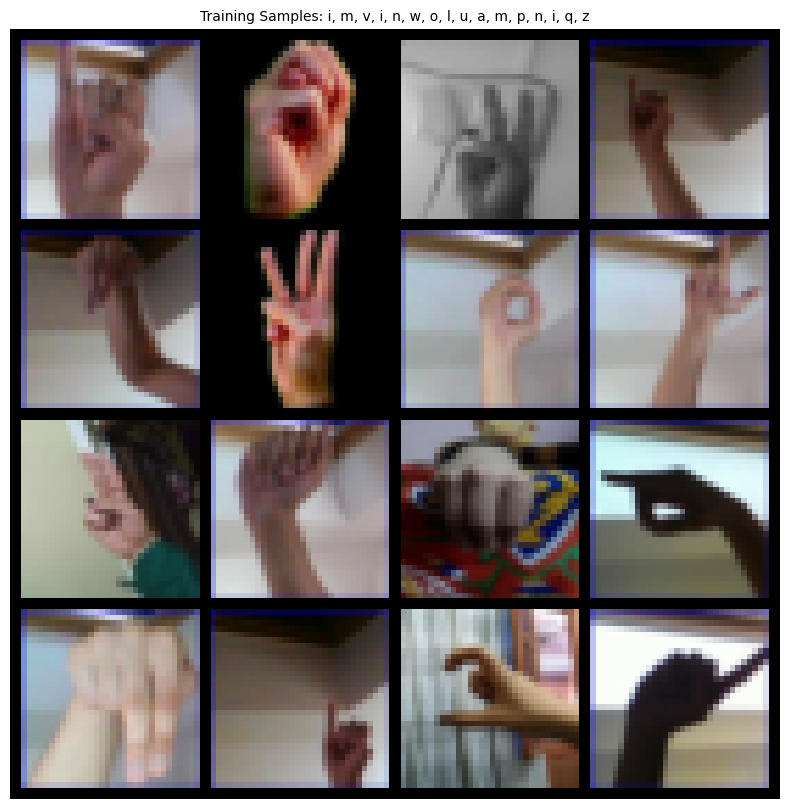

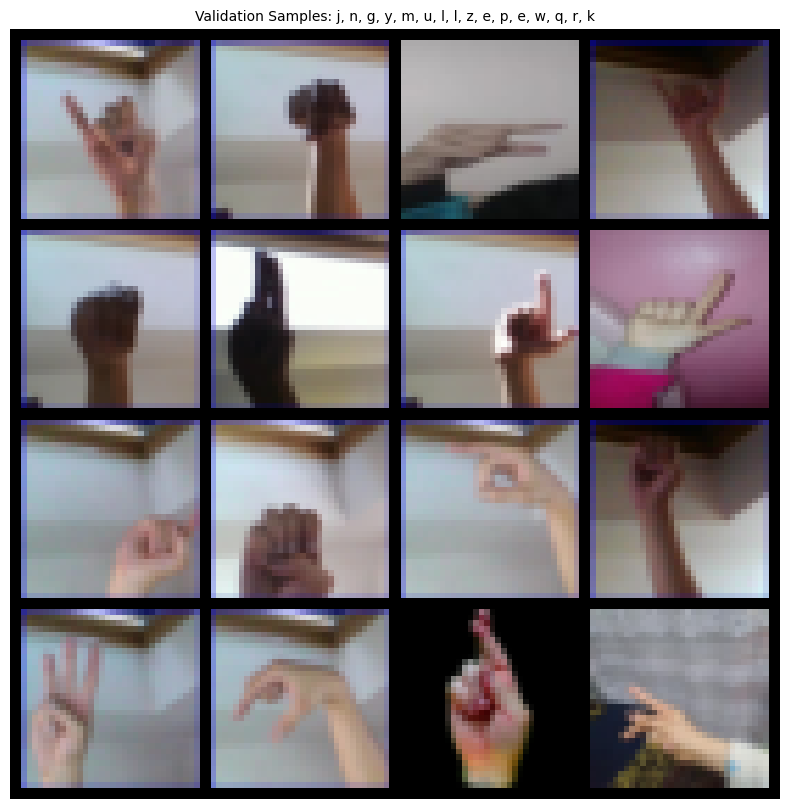

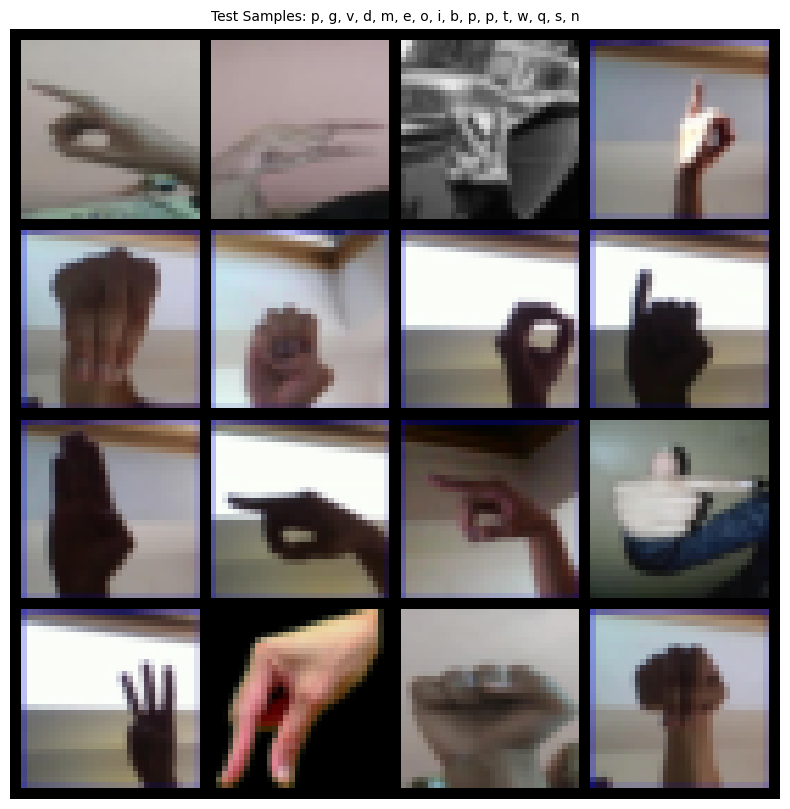

In [16]:
# Visualize a few random samples from a dataset split (train/val/test)
def visualize_batch(dataset, title):

    # Randomly select up to 16 indices from the dataset
    indices = random.sample(range(len(dataset)), min(16, len(dataset)))

    images = [dataset[i][0] for i in indices]  # Get image tensors
    labels = [class_names[dataset[i][1]] for i in indices]  # Get label names

    # Create a grid of the selected images (4 per row)
    grid_img = make_grid(images, nrow=4, padding=2, normalize=True)

    # Plot the grid using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_img.permute(1, 2, 0))  # Convert (C, H, W) → (H, W, C) for display

    # Add a title that includes the label names
    label_string = ', '.join(labels)
    plt.title(f"{title}: {label_string}", fontsize=10)

    plt.axis('off')
    plt.show()

# Visualize examples from each dataset split
visualize_batch(train_data, "Training Samples")
visualize_batch(val_data, "Validation Samples")
visualize_batch(test_data, "Test Samples")

## 13. Create the Dataloaders (Student Work Required)

In [19]:
# Create a DataLoader for the training set
# - batch_size: use a batch size of 64
# - shuffle: Randomize order each epoch for better generalization
# - num_workers=2: Use 2 background worker processes to load data in parallel
# - pin_memory=True: Speed up GPU transfer by keeping data in page-locked memory
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)

# DataLoader for the validation set
# - batch_size: use a batch size of 64
# - shuffle: Keep order fixed for consistent evaluation
# - num_workers=2, pin_memory=True: Improve throughput and memory transfer **Not as useful as with the Train Loader, but can still help if your dataset is large or if using GPU**
val_loader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

# DataLoader for the test set
# - batch_size: use a batch size of 64
# - shuffle: Preserve original order for reporting
# - num_workers=2, pin_memory=True: Efficient data loading **Not as useful as with the Train Loader, but can still help if your dataset is large or if using GPU**
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)


## 14. Set Device

In [17]:
# Device configuration
# This determines whether we use a GPU (if available) or default to a CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 15. Training  (Student Work Required)

In [20]:
# Define model save directory and path for the best model
model_save_dir = 'Practical_4/models'
os.makedirs(model_save_dir, exist_ok=True)
run_timestamp = datetime.now().strftime('%Y%m%d-%H%M%S')
best_model_path = os.path.join(model_save_dir, f'asl_resnet_best_{run_timestamp}.pth')

# Initialize the model and move it to the device
model = CustomResNet(num_classes=29).to(device)

# Use cross entropy loss
criterion = nn.CrossEntropyLoss()

# Instantiate your optimizer as Adam with a learning rate of 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize a variable to track the best validation accuracy
best_val_acc = 0.0

# Set up a training loop to run for 20 epochs
for epoch in range(20):

    # Set the model into training mode
    model.train()

    # Create a variable to track running loss
    running_loss = 0.0

    # Wrap the training DataLoader with tqdm to show a live progress bar.
    # The description displays the epoch number, and leave=True keeps the progress bar after the epoch.
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=True)

    # Loop over the training data
    for inputs, labels in loop:
        # Move inputs and labels to the same device as the model (e.g., GPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Clear previous gradients
        optimizer.zero_grad()

        # Forward pass to collect model outputs (ignoring encodings)
        outputs, _ = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backpropagation
        loss.backward()

        # Update weights
        optimizer.step()

        # Update 'running_loss' by accumulating the total loss across batches for this epoch
        running_loss += loss.item()

        # Update the tqdm progress bar with the current loss value for real time monitoring
        loop.set_postfix(loss=loss.item())

    # Run validation after each epoch
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, _ = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    print(f"Epoch {epoch+1}: Loss={running_loss:.4f}, Val Acc={val_acc:.4f}")

    # Save model only if it's the best so far
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model updated and saved with Val Acc = {val_acc:.4f}")

print(f"Training complete. Best model saved to: {best_model_path}")


Epoch 1: 100%|██████████| 239/239 [00:20<00:00, 11.66it/s, loss=1.22]


Epoch 1: Loss=523.1849, Val Acc=0.5074
Best model updated and saved with Val Acc = 0.5074


Epoch 2: 100%|██████████| 239/239 [00:17<00:00, 13.39it/s, loss=0.371]


Epoch 2: Loss=214.7893, Val Acc=0.7784
Best model updated and saved with Val Acc = 0.7784


Epoch 3: 100%|██████████| 239/239 [00:18<00:00, 13.02it/s, loss=0.427]


Epoch 3: Loss=104.2560, Val Acc=0.7951
Best model updated and saved with Val Acc = 0.7951


Epoch 4: 100%|██████████| 239/239 [00:19<00:00, 12.44it/s, loss=0.36]


Epoch 4: Loss=56.7100, Val Acc=0.8446
Best model updated and saved with Val Acc = 0.8446


Epoch 5: 100%|██████████| 239/239 [00:19<00:00, 12.35it/s, loss=0.284]


Epoch 5: Loss=35.3565, Val Acc=0.9040
Best model updated and saved with Val Acc = 0.9040


Epoch 6: 100%|██████████| 239/239 [00:18<00:00, 12.58it/s, loss=0.0315]


Epoch 6: Loss=25.9718, Val Acc=0.9270
Best model updated and saved with Val Acc = 0.9270


Epoch 7: 100%|██████████| 239/239 [00:18<00:00, 13.05it/s, loss=0.215]


Epoch 7: Loss=18.0458, Val Acc=0.9097


Epoch 8: 100%|██████████| 239/239 [00:18<00:00, 12.95it/s, loss=0.07]


Epoch 8: Loss=15.0755, Val Acc=0.9342
Best model updated and saved with Val Acc = 0.9342


Epoch 9: 100%|██████████| 239/239 [00:18<00:00, 12.96it/s, loss=0.142]


Epoch 9: Loss=9.6260, Val Acc=0.9123


Epoch 10: 100%|██████████| 239/239 [00:18<00:00, 12.93it/s, loss=0.064]


Epoch 10: Loss=15.6242, Val Acc=0.9403
Best model updated and saved with Val Acc = 0.9403


Epoch 11: 100%|██████████| 239/239 [00:19<00:00, 12.55it/s, loss=0.0295]


Epoch 11: Loss=6.1446, Val Acc=0.9474
Best model updated and saved with Val Acc = 0.9474


Epoch 12: 100%|██████████| 239/239 [00:19<00:00, 12.39it/s, loss=0.0228]


Epoch 12: Loss=8.2628, Val Acc=0.9386


Epoch 13: 100%|██████████| 239/239 [00:19<00:00, 12.26it/s, loss=0.0123]


Epoch 13: Loss=19.4466, Val Acc=0.9252


Epoch 14: 100%|██████████| 239/239 [00:18<00:00, 12.89it/s, loss=0.00215]


Epoch 14: Loss=7.3327, Val Acc=0.9629
Best model updated and saved with Val Acc = 0.9629


Epoch 15: 100%|██████████| 239/239 [00:17<00:00, 13.37it/s, loss=0.00619]


Epoch 15: Loss=6.0155, Val Acc=0.9633
Best model updated and saved with Val Acc = 0.9633


Epoch 16: 100%|██████████| 239/239 [00:18<00:00, 13.21it/s, loss=0.00363]


Epoch 16: Loss=4.0282, Val Acc=0.9488


Epoch 17: 100%|██████████| 239/239 [00:18<00:00, 13.16it/s, loss=0.0174]


Epoch 17: Loss=9.4901, Val Acc=0.9282


Epoch 18: 100%|██████████| 239/239 [00:19<00:00, 12.16it/s, loss=0.081]


Epoch 18: Loss=13.9215, Val Acc=0.9472


Epoch 19: 100%|██████████| 239/239 [00:18<00:00, 12.67it/s, loss=0.00258]


Epoch 19: Loss=8.2710, Val Acc=0.9154


Epoch 20: 100%|██████████| 239/239 [00:18<00:00, 13.08it/s, loss=0.00502]


Epoch 20: Loss=7.0026, Val Acc=0.9615
Training complete. Best model saved to: Practical_4/models/asl_resnet_best_20250326-200140.pth


## 16. Load the best model

This code will load the best model from the most recent training run. If you perform multiple training runs you can edit this code to load the model of a previous run.

In [21]:
# Load best model
# If you ran training multiple times you will have numerous best model files.
# The code below will load the best model from your latest training run.
model.load_state_dict(torch.load(f'Practical_4/models/asl_resnet_best_{run_timestamp}.pth'))


<All keys matched successfully>

## 17. Test Set Evaluation

In [22]:
# Define the output directory for saving misclassified images
# - Uses run_timestamp to uniquely identify this evaluation run
misclassified_root = f"Practical_4/misclassified/{run_timestamp}"
os.makedirs(misclassified_root, exist_ok=True)

# Put model in evaluation mode (disables dropout, etc.)
model.eval()

# Lists to collect all predictions, true labels, and original images
all_preds, all_labels, all_images = [], [], []

# Disable gradient calculations for inference
with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(test_loader):
        # Move inputs and labels to the same device as the model (e.g., GPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass through the model
        outputs, _ = model(inputs)

        # Get predicted class indices (batch-wise)
        preds = torch.argmax(outputs, dim=1)

        # Store predictions and labels as numpy arrays for later evaluation
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Store original image tensors for optional Grad-CAM or later use
        all_images.extend(inputs)

        # Iterate through the batch and save any misclassified images
        for i in range(len(inputs)):
            if preds[i] != labels[i]:
                true_label = class_names[labels[i]]  # Convert label index to string name
                pred_label = class_names[preds[i]]  # Convert prediction index to string name

                filename = f"batch-{batch_idx}_img-{i}_true-{true_label}_pred-{pred_label}.png"
                save_path = os.path.join(misclassified_root, filename)

                # Unnormalize and resize image for saving
                img = F.resize(inputs[i].cpu() * 0.5 + 0.5, size=(256, 256))
                save_image(img, save_path)

print(f"Misclassified images saved to: {misclassified_root}")


Misclassified images saved to: Practical_4/misclassified/20250326-200140


## 18. Creating a Classification Report (Student Work Required)

The classification report summarizes key performance metrics for each class:



#### **Precision**

- Out of all the times the model predicted a given class, how many of those predictions were correct?

- Precision = True Positives / (True Positives + False Positives)

- Interpretation: High precision means the model is **not easily fooled** into predicting that class when it shouldn't.



#### **Recall (Sensitivity)**

- Out of all the actual samples of a given class, how many did the model correctly identify?

- Recall = True Positives / (True Positives + False Negatives)

- High recall means the model is **good at finding all instances** of that class.


### **F1-Score**

- The harmonic mean of precision and recall, providing a single score that balances both.

- F1 = 2 * (Precision * Recall) / (Precision + Recall)

- A high F1-score indicates a **good balance between precision and recall**.



### Support

- The number of actual occurrences of each class in the test set.

- This helps assess whether a class is underrepresented and how that may affect metrics.


In [24]:
# Classification Report
print("Classification Report:")

# Generate and print a detailed classification report: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
# - all_labels: Ground truth labels from the test set
# - all_preds: Predicted labels from the model
# - target_names: List of class names to make the output more readable

report = classification_report(all_labels, all_preds, target_names=class_names)
print(report)



Classification Report:
              precision    recall  f1-score   support

           a       0.97      0.97      0.97       196
           b       0.98      0.91      0.94       196
           c       1.00      0.97      0.99       196
           d       0.99      0.99      0.99       196
           e       0.97      0.97      0.97       196
           f       1.00      0.93      0.97       196
           g       0.97      0.99      0.98       196
           h       0.98      0.97      0.98       196
           i       1.00      0.96      0.98       196
           j       0.93      0.98      0.96       196
           k       0.93      0.94      0.93       196
           l       0.98      0.96      0.97       196
           m       0.96      0.98      0.97       196
           n       0.97      0.96      0.96       196
           o       0.98      0.96      0.97       196
           p       0.97      0.98      0.98       196
           q       0.99      0.98      0.98       196
    

## 19. Generating a Confusion Matrix (Student Work Required)

A **confusion matrix** is a commonly used performance evaluation tool for classification models. It provides a **summary of prediction results** on a set of labeled data, showing how often the model predicts each class correctly — and where it makes mistakes.

The matrix compares the **actual (true)** class labels with the **predicted** labels, and organizes them into a square grid. Each row typically represents the actual class, while each column represents the predicted class.


### Benefits of a Confusion Matrix

- Helps **visualize model accuracy** per class  
- Quickly **identify which classes are confused** with one another  
- See **imbalanced performance** across different categories  
- Works as a complement to overall metrics like accuracy or F1-score with **fine-grained insight**


### How to read it:

For a confusion matrix of size *N x N* (where *N* is the number of classes):

- **Diagonal entries** represent the number of times the model correctly predicted each class (true positives).
- **Off-diagonal entries** show where the model made mistakes (false positives and false negatives).
- Rows typically show how many samples of each actual class were **misclassified**.
- Columns show how many predictions were made for each predicted class, whether correct or not.

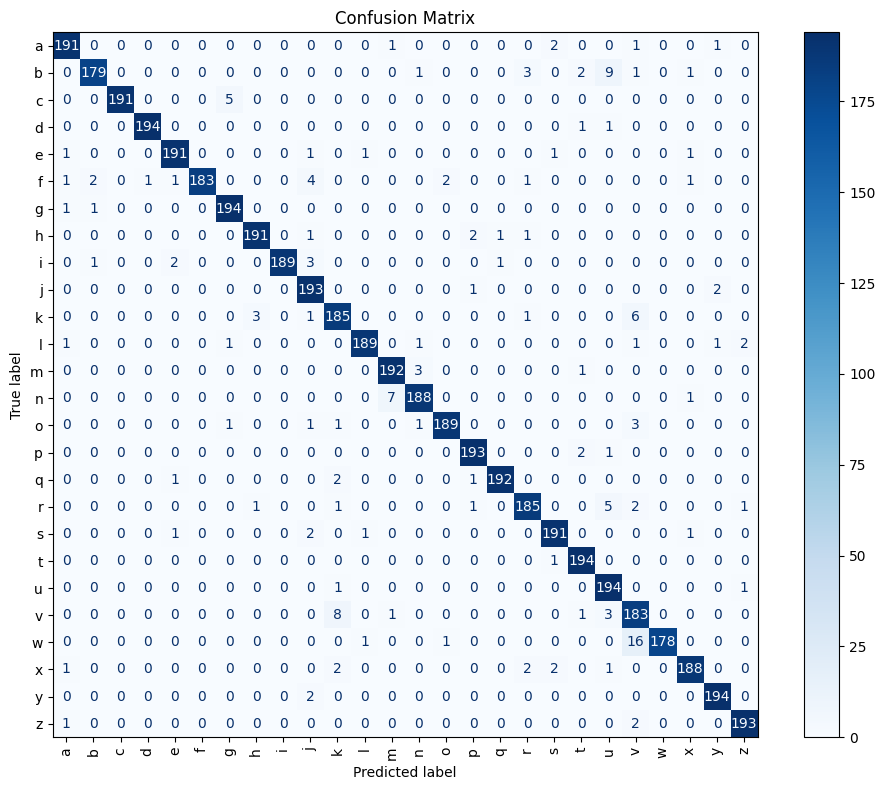

In [25]:
# Compute the confusion matrix using true labels and predictions
cm = confusion_matrix(all_labels, all_preds)

# Create a new figure and axis for plotting with a figure size of (10, 8)
fig, ax = plt.subplots(figsize=(10, 8))

# Use scikit-learn's display class to plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, xticks_rotation='vertical', cmap=plt.cm.Blues)

# Add a title to the plot
ax.set_title("Confusion Matrix")

# Automatically adjust layout so labels and titles aren't cut off
plt.tight_layout()

# Display the final plot
plt.show()


## 20. Grad-CAM

**Grad-CAM (Gradient-weighted Class Activation Mapping)** is a visualization technique that helps us understand **which regions of an input image were important** for a model’s prediction. It is particularly useful in Convolutional Neural Networks (CNNs) or in our case the convolutional layers of our CustomResNet model, where spatial feature maps are preserved.


Grad-CAM works by computing the **gradient of the output score for a specific class** (usually the predicted class) with respect to the **feature maps in a chosen convolutional layer**. These gradients are then globally averaged and used to weight the feature maps. The resulting weighted combination highlights the regions that had the **strongest influence on the model’s decision**.

### Benefits of Grad-CAM

- It helps us **interpret model decisions** visually  
- It can be used to **debug and improve CNNs**, especially when they make mistakes  
- We can **gain insight** into what features the model has learned  
- TIt helps to establish **model trustworthiness** in critical applications (e.g., medical imaging, sign language recognition)  

### What you’ll see in our Grad-CAM visualization exercise:

- The original image side-by-side with a **heatmap overlay** (Grad-CAM returns the heatmap overlay, I added the original image for better visualization)
- Bright regions indicate **high importance** for the predicted class  
- Dim or neutral regions are **less influential**

### Key Parameters in Practice:

- `target_layer`: A layer from your model (usually the **last convolutional block**) that captures rich spatial information.  
- `ClassifierOutputTarget`: Specifies which class you want Grad-CAM to focus on. This is typically set as the predicted class, but can be manually set to explore other possibilities.  
- `show_cam_on_image`: Combines the Grad-CAM heatmap with the original image for intuitive visualization.


In [26]:
def visualize_gradcam(model, class_names, images, labels, preds, max_images=3, target_layer=None):
    """
    Visualizes Grad-CAM results for a list of images, labels, and predictions.

    Args:
        model: Trained PyTorch model.
        class_names: List of class names.
        images: Tensor [B, C, H, W] (on GPU or CPU).
        labels: Tensor of true class indices.
        preds: Tensor of predicted class indices.
        max_images: Number of samples to visualize.
        target_layer: Optional model layer for Grad-CAM (defaults to model.layer4[-1]).
    """
    model.eval()

    device = next(model.parameters()).device
    if target_layer is None:
        target_layer = model.layer4[-1]

    with GradCAM(model=model, target_layers=[target_layer]) as cam:
        for i in range(min(max_images, len(images))):
            input_tensor = images[i].unsqueeze(0).to(device)
            label = labels[i].item()
            pred = preds[i].item()

            # Convert to numpy for display
            rgb_img = images[i].detach().cpu().permute(1, 2, 0).numpy()
            rgb_img = (rgb_img * 0.5 + 0.5).clip(0, 1)  # unnormalize

            grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(pred)])[0, :]
            visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

            # Plot original + Grad-CAM side by side
            fig, axs = plt.subplots(1, 2, figsize=(8, 4))
            axs[0].imshow(rgb_img)
            axs[0].set_title(f"Original\nTrue: {class_names[label]}")
            axs[0].axis('off')

            axs[1].imshow(visualization)
            axs[1].set_title(f"Grad-CAM\nPred: {class_names[pred]}")
            axs[1].axis('off')

            plt.tight_layout()
            plt.show()


## 21. Preparing the Data for Grad-CAM

We need to convert everything to tensors to use with Grad-CAM, which expects batched image tensors and corresponding label/prediction tensors.




In [27]:
# Convert a list of image tensors into a single 4D tensor with shape (N, C, H, W)
# - all_images should be a list of preprocessed image tensors
images = torch.stack(all_images)

# Convert the list of true labels into a 1D tensor of shape (N,)
labels = torch.tensor(all_labels)
print(labels)
print(len(labels))

# Convert the list of predicted labels into a 1D tensor of shape (N,)
preds = torch.tensor(all_preds)
print(preds)
print(len(preds))

tensor([ 1, 22,  3,  ..., 13, 21,  9])
5095
tensor([ 1, 22,  3,  ..., 13, 21,  9])
5095


## 21. Using Grad-CAM Example

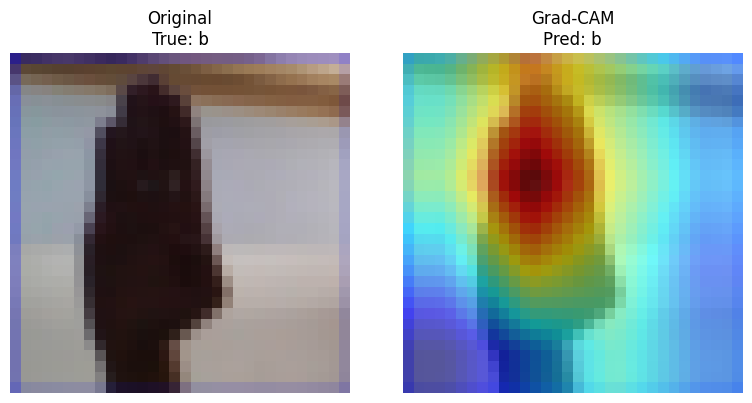

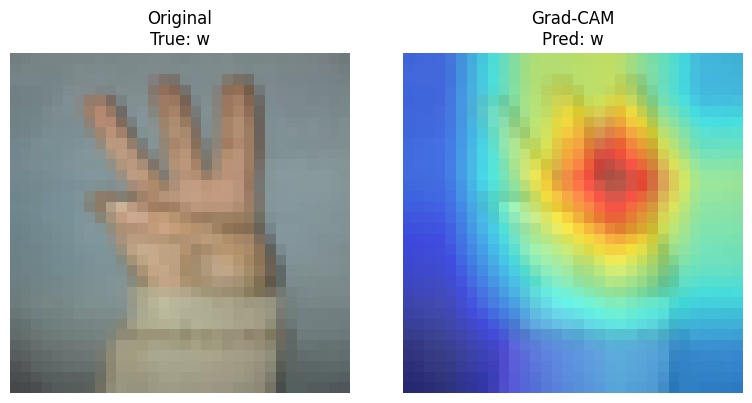

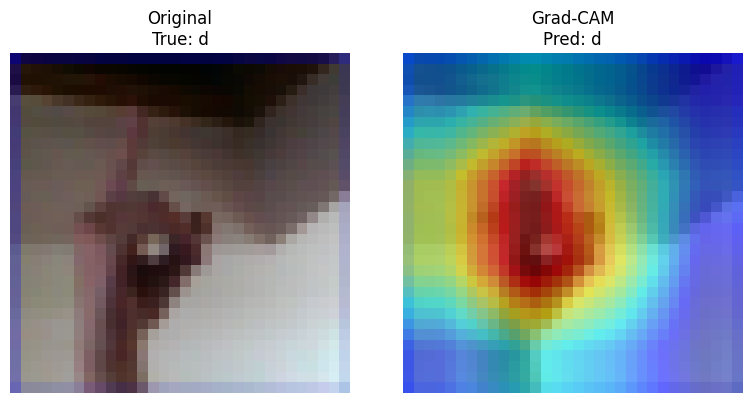

In [28]:
# Run Grad-Cam on some of the images in the data
visualize_gradcam(model, class_names, images, labels, preds)

## 22. Using Grad-CAM on a Target **Class** (Student Work Required)

Generate Grad-CAM visualizations for one of your best performing classes. Only include correct predictions. In other words, find all the indices where both the predicted label and the true label are equal to the target class.

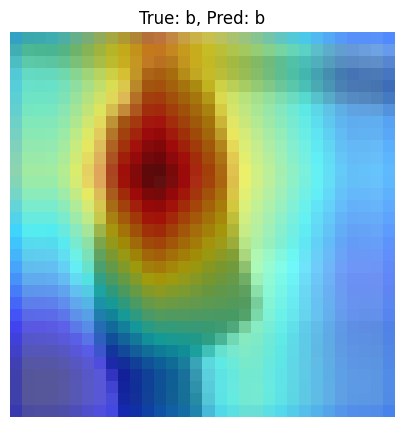

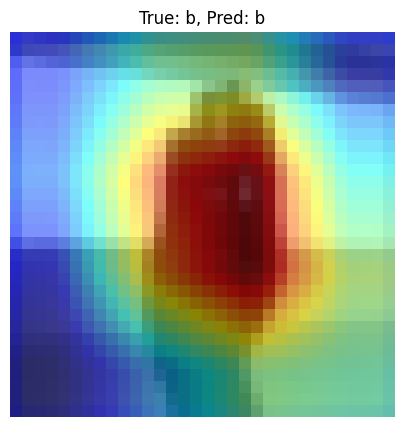

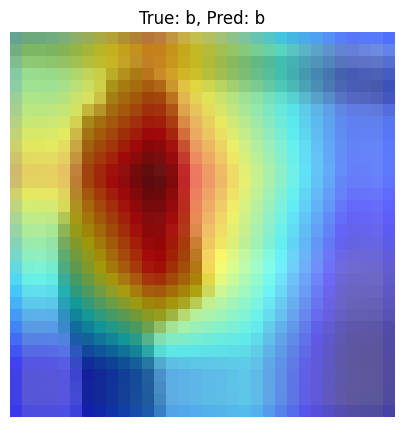

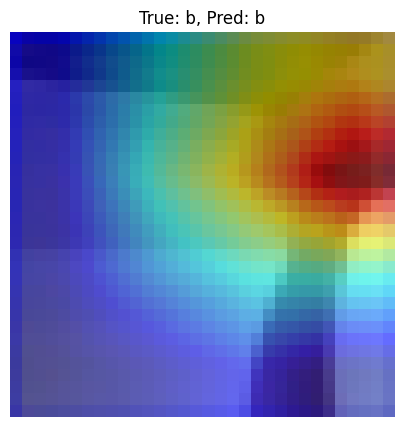

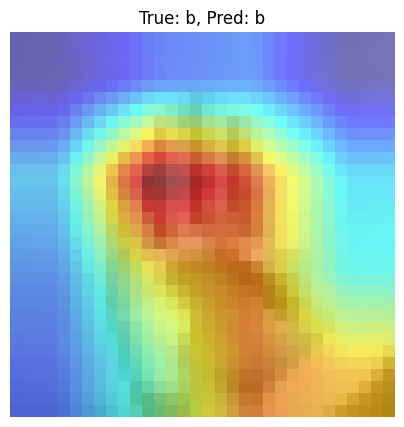

In [36]:
# Get the class index for one of your best performing classes. (e.g., "b")
# - Converts class name string to its corresponding index in class_names list
target_class = class_names.index("b")

# Find all indices where both the predicted label and the true label are equal to the target class
# - Loop over all true and predicted labels
# - For each item, check if both the true label and the predicted label match the target class (i.e., correct predictions of that class)
# - Store the index if both match
indices = [i for i, (true, pred) in enumerate(zip(all_labels, all_preds))
           if true == target_class and pred == target_class]

# Extract only the images corresponding to the correctly predicted target class
images_target_class = [all_images[i] for i in indices]

# Extract true labels (should all match the target class)
labels_target_class = [all_labels[i] for i in indices]

# Extract predicted labels (should also match the target class)
preds_target_class = [all_preds[i] for i in indices]

# Visualize Grad-CAM heatmaps for correctly classified samples of the target class
# - model: your trained model
# - class_names: list of class labels
# - images: tensor of target class images
# - labels: tensor of true labels for the target class images
# - preds: tensor of predicted labels for the target class images
# - max_images: Use a max_image count between 5 and 10 inclusive to return enough images for analysis

# Since our model's forward returns (logits, encodings), we create a wrapper to return only logits.
class ModelWrapper(nn.Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model
    def forward(self, x):
        logits, _ = self.model(x)
        return logits

wrapped_model = ModelWrapper(model)

# Choose the target layer for Grad-CAM (e.g., the last block of layer4)
target_layer = model.layer4[-1]

# Initialize GradCAM with the wrapped model (removing use_cuda if unsupported)
cam = GradCAM(model=wrapped_model, target_layers=[target_layer])

# Set the maximum number of images to visualize (choose between 5 and 10)
max_images = 5

# Limit the images, labels, and predictions to the first max_images samples
images_to_vis = images_target_class[:max_images]
labels_to_vis = labels_target_class[:max_images]
preds_to_vis = preds_target_class[:max_images]

# Visualize Grad-CAM heatmaps for each image in images_to_vis
for idx, image in enumerate(images_to_vis):
    # Convert image tensor to numpy array and unnormalize it for visualization.
    # Assumes the images were normalized with mean=0.5 and std=0.5.
    image_np = image.cpu().numpy().transpose(1, 2, 0)
    image_np = (image_np * 0.5) + 0.5  # Convert back to [0, 1] range

    # Compute the Grad-CAM heatmap; the output is a grayscale map with the same spatial dimensions.
    grayscale_cam = cam(input_tensor=image.unsqueeze(0))[0, :]

    # Overlay the heatmap on the image using pytorch_grad_cam's utility function.
    cam_image = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)

    # Plot the image with the Grad-CAM heatmap
    plt.figure(figsize=(5, 5))
    plt.title(f"True: {class_names[labels_to_vis[idx]]}, Pred: {class_names[preds_to_vis[idx]]}")
    plt.imshow(cam_image)
    plt.axis('off')
    plt.show()


## 23. Using Grad-CAM on the Misclassified images (Student Work Required)

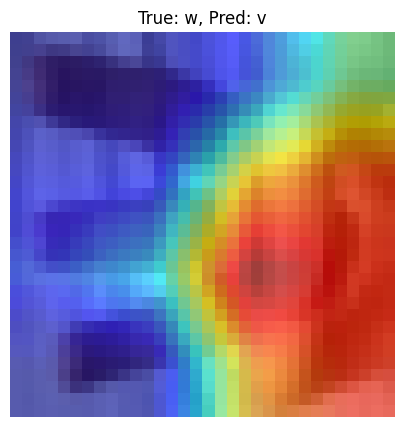

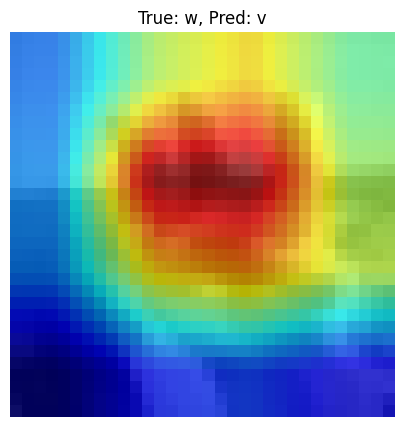

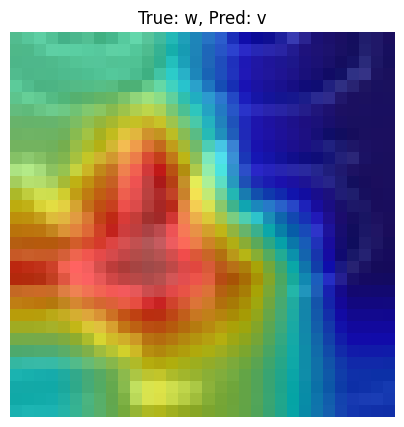

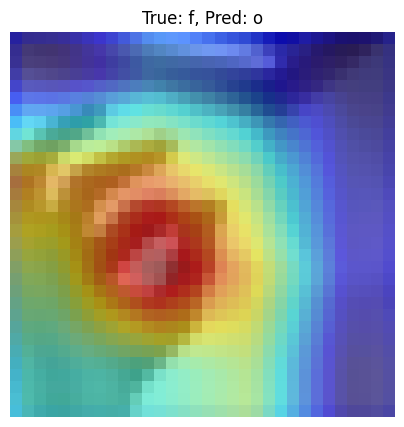

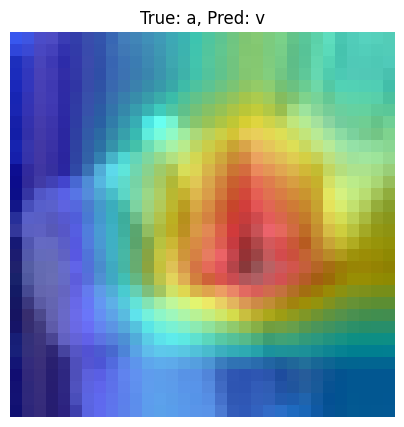

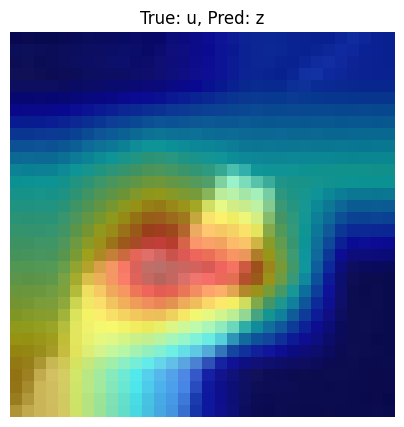

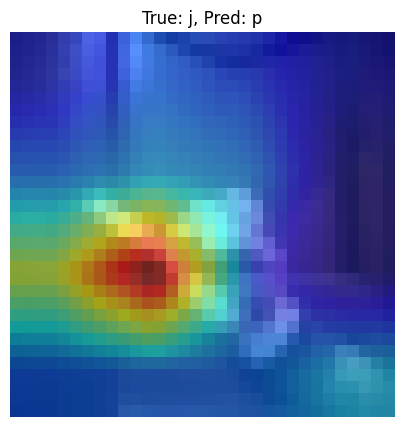

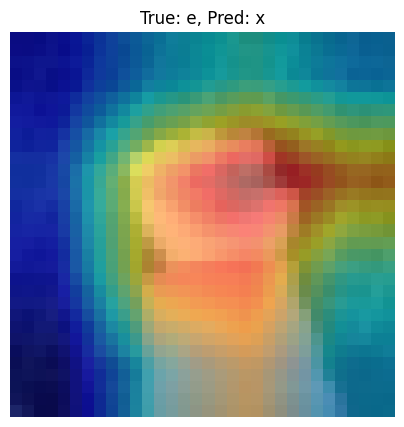

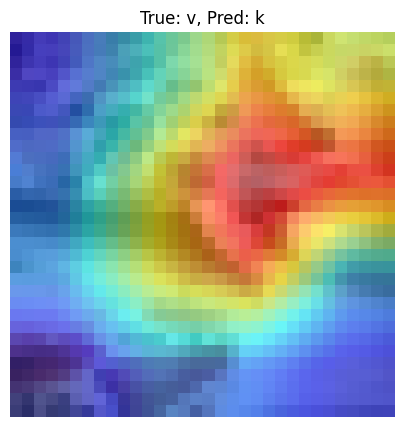

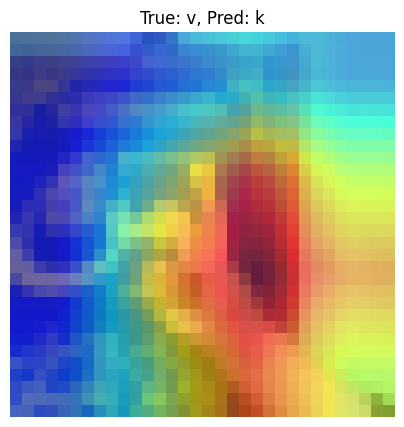

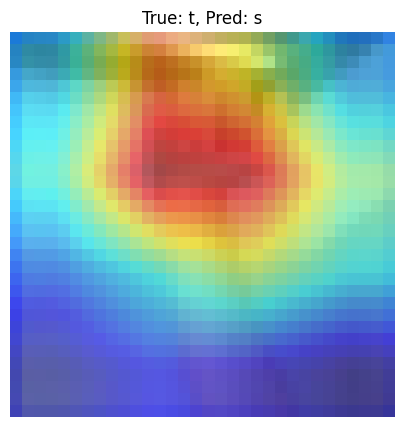

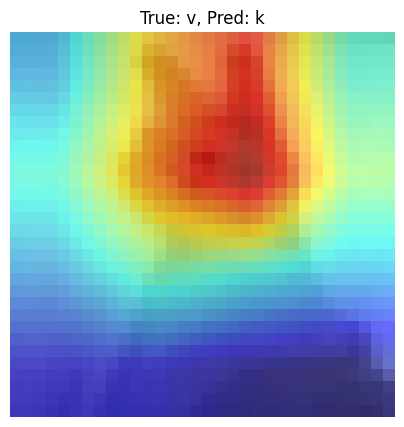

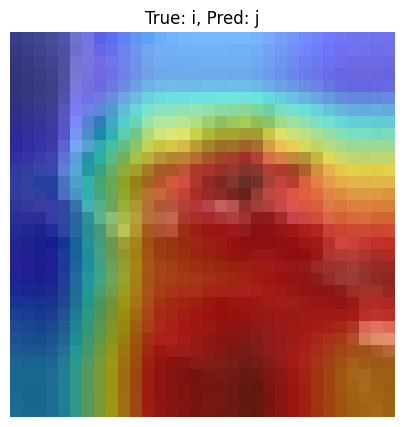

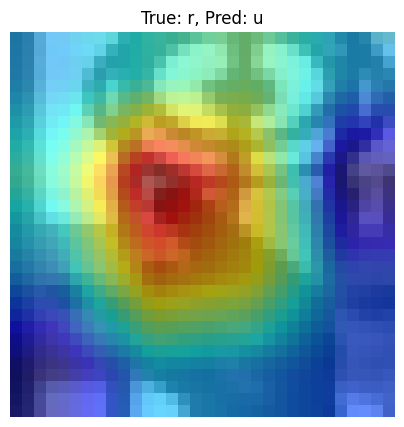

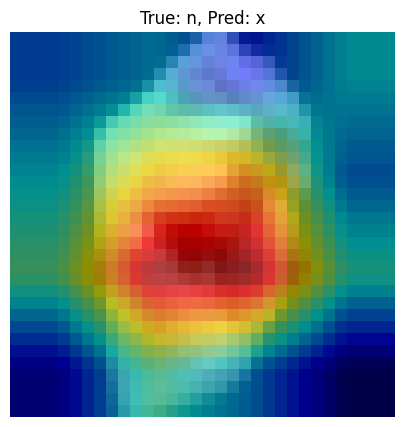

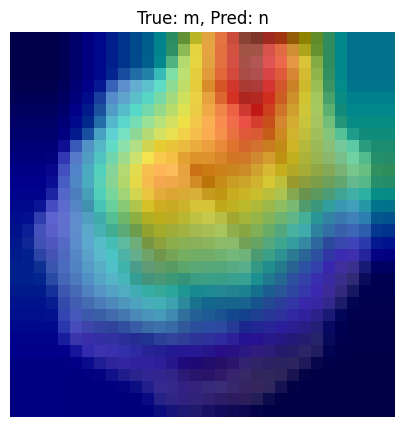

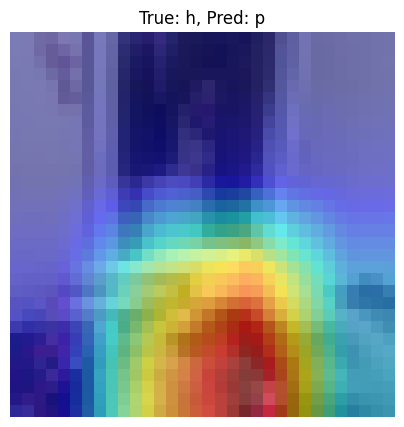

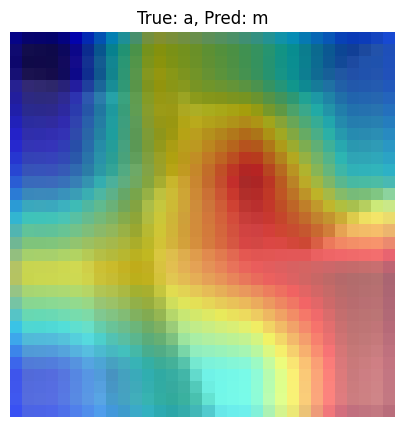

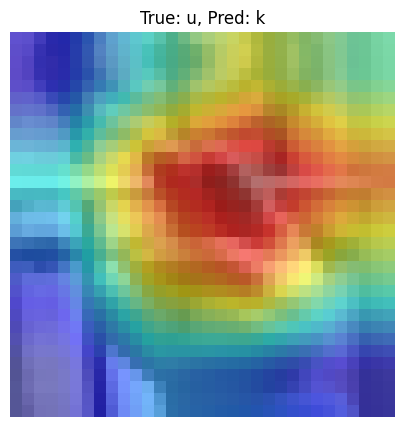

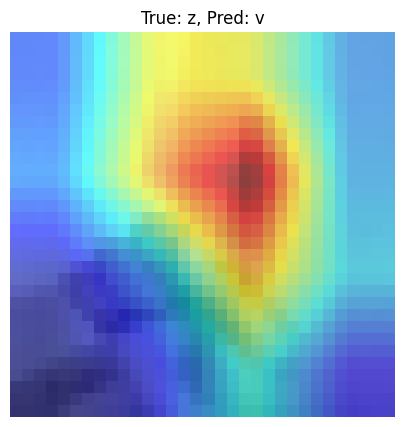

In [37]:
# Identify misclassified sample indices by comparing predicted vs. true labels
# - Loop over each index `i` for the entirety of the dataset
# - Keep only those where the predicted class does not match the true class
misclassified_indices = [i for i in range(len(all_labels)) if all_labels[i] != all_preds[i]]

# Use the identified indices to select only the misclassified images
misclassified_images = [all_images[i] for i in misclassified_indices]

# Select the corresponding true labels for the misclassified images
misclassified_labels = [all_labels[i] for i in misclassified_indices]

# Select the predicted labels for the misclassified images
misclassified_preds = [all_preds[i] for i in misclassified_indices]

# ---------------------------
# Grad-CAM Visualization Setup
# ---------------------------
# (If you haven't already wrapped your model for Grad-CAM, do so here)
# This wrapper makes sure that only the logits are returned (GradCAM requires a tensor, not a tuple)
class ModelWrapper(nn.Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model
    def forward(self, x):
        logits, _ = self.model(x)
        return logits

wrapped_model = ModelWrapper(model)
# Select a target layer (for example, the last block of model.layer4)
target_layer = model.layer4[-1]

# Initialize GradCAM without additional unsupported arguments
from pytorch_grad_cam import GradCAM
cam = GradCAM(model=wrapped_model, target_layers=[target_layer])

# ---------------------------
# Visualize Grad-CAM for Misclassified Samples
# ---------------------------
# Choose a maximum image count of at least 20
max_images = 20

# Limit the misclassified samples to the first max_images entries
images_to_vis = misclassified_images[:max_images]
labels_to_vis = misclassified_labels[:max_images]
preds_to_vis = misclassified_preds[:max_images]

# Loop through each misclassified sample and visualize its Grad-CAM heatmap
for idx, image in enumerate(images_to_vis):
    # Convert the image tensor to a numpy array and unnormalize it.
    # This assumes the images were normalized with mean=0.5 and std=0.5.
    image_np = image.cpu().numpy().transpose(1, 2, 0)
    image_np = (image_np * 0.5) + 0.5  # unnormalize to [0, 1] range

    # Compute the Grad-CAM heatmap; the output is a grayscale map with the same spatial dimensions.
    grayscale_cam = cam(input_tensor=image.unsqueeze(0))[0, :]

    # Overlay the Grad-CAM heatmap on the original image using pytorch_grad_cam's utility function.
    from pytorch_grad_cam.utils.image import show_cam_on_image
    cam_image = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)

    # Plot the Grad-CAM visualization using matplotlib.
    import matplotlib.pyplot as plt
    plt.figure(figsize=(5, 5))
    plt.title(f"True: {class_names[labels_to_vis[idx]]}, Pred: {class_names[preds_to_vis[idx]]}")
    plt.imshow(cam_image)
    plt.axis('off')
    plt.show()


## 24. t-SNE (t-Distributed Stochastic Neighbor Embedding)

t-SNE is a dimensionality reduction technique that's especially useful for visualizing high-dimensional data (like neural network embeddings) in 2D or 3D space.

In the context of deep learning, t-SNE is applied to the feature representations (embeddings) learned by a model (typically the output of a layer just before classification). This helps us understand:

Whether the model is learning meaningful separation between classes

1.   Whether the model is learning meaningful separation between classes
2.   How similar different samples or classes appear to the model
3.   Whether fine-tuning or domain shift affects the feature space


In [38]:
# Select a 20% subset of the training data for visualization
subset_len = int(0.2 * len(train_data))
subset, _ = torch.utils.data.random_split(train_data, [subset_len, len(train_data) - subset_len])

# Prepare a DataLoader for the subset (no shuffling needed)
subset_loader = DataLoader(subset, batch_size=64, shuffle=False)

# Store extracted features and their corresponding labels
features, labels = [], []

# Put the model into evaluation mode and disable gradient tracking
model.eval()
with torch.no_grad():
    for inputs, targets in subset_loader:
        inputs = inputs.to(device)

        # Forward pass to extract features from the penultimate layer
        _, enc = model(inputs)  # 'enc' is the embedding before the final classification layer

        features.append(enc.cpu().numpy())       # Move features to CPU and convert to NumPy
        labels.extend(targets.cpu().numpy())     # Store the ground truth class labels

# Concatenate all batches into one feature matrix and label array
features = np.concatenate(features)
labels = np.array(labels)

# Run t-SNE to reduce the high-dimensional features to 2D for visualization
tsne = TSNE(n_components=2,          # Project to 2D space
            perplexity=30,           # Balance between local/global structure
            n_iter=1000,             # Number of optimization iterations
            random_state=42)         # For reproducibility

tsne_results = tsne.fit_transform(features)  # Apply t-SNE to the feature matrix

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


## 25. Applying t-SNE and plotting tsne_results with color-coded labels

This will allow you to:

1.  See clusters of similar inputs

2.  Evaluate how well-separated the classes are

3.  Get intuition for how your model "sees" the data

If the t-SNE plot shows tight clusters of points corresponding to individual classes, it indicates that the model has learned a meaningful internal representation that separates the classes well.

If there is significant overlap between points from different classes, it suggests that the model may be confusing those classes, and there could be room for improvement in either the training data, model architecture, or learning process.

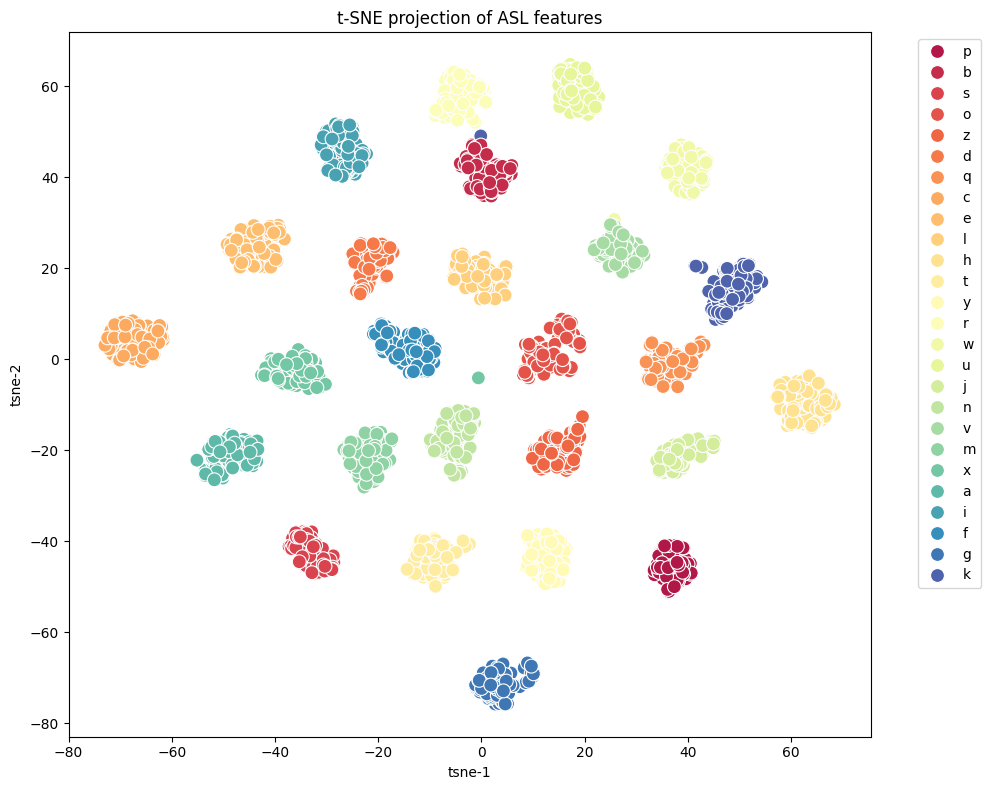

In [39]:
# Create a DataFrame for visualization that includes:
# - The 2D t-SNE coordinates for each sample
# - The corresponding class label as a string (from class_names)
vis_df = pd.DataFrame({
    'tsne-1': tsne_results[:, 0],                    # x-axis coordinate
    'tsne-2': tsne_results[:, 1],                    # y-axis coordinate
    'label': [class_names[i] for i in labels]        # Convert label indices to class names
})

# Set the figure size for the plot
plt.figure(figsize=(10, 8))

# Create a scatterplot using seaborn
# - Each point represents a sample in the 2D t-SNE space
# - Points are colored by class label
# - 's=100' sets the marker size
sns.scatterplot(
    data=vis_df,
    x='tsne-1',
    y='tsne-2',
    hue='label',
    palette='Spectral',      # Choose a colorful palette for class distinction
    s=100                    # Size of the points
)

# Add a title to the plot
plt.title('t-SNE projection of ASL features')

# Move the legend outside the plot for better visibility
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout so nothing is clipped
plt.tight_layout()

# Save the figure as a PNG image
plt.savefig("Practical_4/tsne_asl.png")

# Display the plot
plt.show()

## 26. Short Answers (Student Work Required)

Please answer the following question with 2-4 sentences. Make sure to include enough detail so that I can give you credit even if your answer ins't entirely correct.

All the answer to these question are located inside this notebook. There should be no need to use outside references or LLMs.

 1. What is the main innovation present in Residual Networks and what problem does this help to solve? By using this innovation what is actually being learned from the network?

Answer:

2. Within the Residual Layers of a Residual Network what are the triggers that cause downsampling to be applied? On what is the downsampling applied? Why?

Answer:

3. We applied Adaptive Average Pooling inside our Residual Network. How does this behavior compare to traditional average pooling? What are the benefits to using it in a highly modular architecture like a Residual Net?

Answer:

4. We brought in multiple ASL datasets and merged them together to create the dataset we eventually used to train and test our model. Why was this important and what are some of the benefits to this approach? Were there any drawbacks that needed to be accounted for in order for the datasets to work together?

Answer:

5. How does ImageFolder function in Torchvision? In your opinion, what are some of the benefits of structuring data to work with it?

Answer:

6. Examine the images that were misclassified during training inside the `Practical_4/misclassified/<model>` folder. What is the highest batch number you see associated with any of the images? What does this tell you about the training? From a general glance, pick a class that was misclassified often during training? Examine a few of the images from that class and provide a reason why you believe the misclassification was more likely to occur for this class.

Answer:

7. What metrics does a classification report track? Which metric do you feel would be most important in our domain of ASL? Why?

Answer:

8. When examing the confusion matrix are there certain classes that under perform comparitively to the rest? Select your worse performing class and explain how it under performed and any potential reasons why.

Answer:

9. Briefly explain Grad-CAM and how it can be used as a tool to help improve models.

Answer:

10. Upon examing the Grad-CAMs you generated for both the Target Class and Misclassified Images what do you notice? Is there a major difference between the Grad-CAMs generated in one scenario vs. the other? If we changed domains do you believe you'd see similar behavior?

Answer:

11. Briefly explain t-SNE and its purpose. At which layer are the embeddings used in t-SNE typically pulled from? Why this layer? If you chose another layer, what do you think you'd see?

Answer:

12. Examine the t-SNE projection graph. What can you say about our classes based on this graph? If we were to train our model for only five epochs instead of twenty how do you think this graph would change?

Answer:

# Create your own Webcam ASL classifier (Just for fun)

After completing this notebook you now have everything you need to create your own ASL Webcam classifier.

Follow this steps:

1.  Create a directory on your local machine to house the necessary files. This isn't required, but will keep it clean. I called mine `ASL_Webcam`.

2.  Navigate to the google Colab `Practical_4` directory and download the `asl_class_names.txt` to the local directory you created in step 1.

3.  Navigate to the `models` directory and download the model file to the local directory you created in step 1. If you only ran the training block once you'll only have one model file, but if you ran it multiple times a file for the best weights of each run will be in the directory.

4. Create a blank python file on your local machine. Copy the imports from the `Model Imports` code block below into your file. Below the imports copy the contents of the entire `ResidualBlock` class into the file. Next, copy the entire contents of the `CustomResNet` class into your file. Save this file as `model.py` to the local directory you created in step 1.

5. Copy the code from the `Webcam Inference` cell below into a blank python file. Update `/path/to/asl_resnet_best.pth` to point to your model's weight file. Save the file in the local directory you created in step 1. I called mine `webcam_inference.py`.

6. Create a local envirnoment for the ASL Webcam to install the needed packages. The necessary libraries to install are torch, torchvision, opencv, Pillow, and numpy. When installing PyTorch (you don't need torchaudio), make sure to follow the instructions on https://pytorch.org/get-started/locally/ to get the command specific to you. I use `Anaconda` on a Windows machine, so your installation steps may vary, but I'll put the install steps I followed below as a guidline.

  - **Anaconda Set-up Example**
    - conda create -n asl-webcam python=3.11 -y
    - conda activate asl-webcam
    - pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118
    - pip install opencv-python Pillow numpy

7. Run your `webcam_inference` file and start signing.

### Model Imports


In [ ]:
import torch
import torch.nn as nn
from torchvision.transforms.functional import resize

### Webcam Inference Code

In [ ]:
import torch
import cv2
import os
from PIL import Image
from torchvision import transforms
from torchvision.transforms.functional import resize
from model import CustomResNet  # Assuming you save your model class in model.py

# Load class names
with open("asl_class_names.txt"), "r") as f:
    class_names = f.read().strip().split(",")
num_classes = len(class_names)

# Define transform
asl_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # For RGB images
])

# Load model
model = CustomResNet(num_classes=num_classes)
model.load_state_dict(torch.load("/path/to/asl_resnet_best.pth"))
model.eval()
model.to("cuda" if torch.cuda.is_available() else "cpu")
device = next(model.parameters()).device

# Prediction function
def predict_from_frame(frame):
    img = cv2.resize(frame, (32, 32))
    img_tensor = asl_transform(Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))).unsqueeze(0).to(device)
    with torch.no_grad():
        output, _ = model(img_tensor)
        pred = torch.argmax(output, dim=1).item()
    return class_names[pred]

# Webcam inference
cap = cv2.VideoCapture(0)
print("Press 'q' to quit")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    label = predict_from_frame(frame)
    cv2.putText(frame, f"Prediction: {label}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    cv2.imshow("ASL Webcam Inference", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()